In [1]:
#Data processing Packages
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist, pdist, squareform
import math
import glob

#Accesing HPO and determining MCA
import networkx as nx
import obonet as obo

#Clustering
from scipy.cluster.hierarchy import dendrogram, linkage

#Visualisation
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

# Data Collection and Processing

### Phenotype-Disease Associations

In [2]:
RTT_DGN_Pheno = pd.read_csv('/Users/ravinschmidl/Desktop/Thesis/Data/Phenotypes/RETT.csv')

path = r'/Users/ravinschmidl/Desktop/Thesis/Data/Phenotypes/Diseases' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

#We are adding all the files of diseases associated to RTT and RTT-like phenotypes
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

PDA = pd.concat(li, axis=0, ignore_index=True) #Phenotype-Disease Associations
PDA

#Get HPO ID by removing the beginning of the link. 
HPOID = PDA["phenotype"].str.split('http://purl.obolibrary.org/obo/', n = 1, expand = True)
HPOID[1] = HPOID[1].str.replace('_',':')
PDA['HPO_ID'] = HPOID[1]


#Get Disease ID
UMLS = PDA["disease"].str.split('http://linkedlifedata.com/resource/umls/id/', n = 1, expand = True)
PDA['UMLS'] = UMLS[1]

PDA = PDA.drop(columns=["source", "sourceTitle", 'phenotype', 'disease'])
PDA['interactionType'] = 'PDA'

print("Number of Diseases in this Dataset: ", PDA.drop_duplicates(subset = 'UMLS').shape)
print("Number of Phenotypes in this Dataset: ", PDA.drop_duplicates(subset = 'HPO_ID').shape)

Number of Diseases in this Dataset:  (3036, 5)
Number of Phenotypes in this Dataset:  (55, 5)


### Gene-Phenotype Assocations

In [3]:
HPO_G2P = pd.read_csv('/Users/ravinschmidl/Desktop/Thesis/Data/HPO/HPO_G2P.csv')
HPO_G2P = HPO_G2P.rename(index=str, columns={"HPO ID": "HPO_ID"})
HPO_G2P['HPO_ID'] = HPO_G2P['HPO_ID'].str.replace('_',':')

#Colors = pd.DataFrame(columns=['code', 'color']) 
#Colors['code'] = RTT_GDA['geneName']
#Colors = Colors.drop_duplicates()
#Colors
HPO_G2P
HPO_G2P = pd.read_csv('/Users/ravinschmidl/Desktop/Thesis/Data/HPO/HPO_G2P.csv')
HPO_G2P = HPO_G2P.rename(index=str, columns={"HPO ID": "HPO_ID"})
HPO_G2P['HPO_ID'] = HPO_G2P['HPO_ID'].str.replace('_',':')

#Colors = pd.DataFrame(columns=['code', 'color']) 
#Colors['code'] = RTT_GDA['geneName']
#Colors = Colors.drop_duplicates()
#Colors

#Check how long 
print("Number of Genes in this Dataset: ", HPO_G2P.drop_duplicates(subset = 'Gene_Symbol').shape)
print("Number of Phenotypes in this Dataset: ", HPO_G2P.drop_duplicates(subset = 'HPO_ID').shape)

#We only want to keep the 55 phenotypes associated to RTT
pg = pd.DataFrame()
pg['HPO_ID'] = PDA['HPO_ID'].drop_duplicates()
Pg = pd.merge(pg, HPO_G2P, on = 'HPO_ID')

Number of Genes in this Dataset:  (38, 5)
Number of Phenotypes in this Dataset:  (871, 5)


In [5]:
#Create Adjacency Matrix of PDA's using Jaccard Distance
PDa = pd.crosstab(PDA['UMLS'], PDA['HPO_ID'])
PDb = squareform(pdist(PDa, metric = '9')) 
#Convert Jaccard Distance to Jaccard Coefficient
PD1 = abs(PDb-1)
#Convert the matrix to dataframe with labels
PD = pd.DataFrame(PD1, index = PDa.index.values, columns = PDa.index.values)

#Create Adjacency Matrix of GDA's using Jaccard Distance
PGa = pd.crosstab(Pg['Gene_Symbol'], Pg['HPO_ID'])
PGb = squareform(pdist(PGa, metric = 'jaccard'))
#Convert Jaccard Distance to Jaccard Coefficient
PG1 = abs(PGb-1)
#Convert the matrix to dataframe with labels
PG = pd.DataFrame(PG1, index = PGa.index.values, columns = PGa.index.values)



In [6]:
PG

,ATP8B1,CDKL5,CHD4,EEF1A2,EIF2B2,EIF4G1,FOXG1,GABBR2,GABRD,GRIN2B,...,SLC35A2,SLC39A13,SLC6A1,SMC1A,STXBP1,SYNE2,SYNGAP1,TBL1XR1,TCF4,WDR45
ATP8B1,1.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,...,0.000000,0.333333,0.000000,0.066667,0.066667,0.000000,0.083333,0.125000,0.125000,0.000000
CDKL5,0.000000,1.000000,0.000000,0.238095,0.200000,0.055556,0.571429,0.555556,0.454545,0.250000,...,0.266667,0.000000,0.117647,0.380952,0.450000,0.052632,0.300000,0.222222,0.192308,0.117647
CHD4,0.000000,0.000000,1.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,...,0.000000,0.333333,0.000000,0.066667,0.066667,0.000000,0.083333,0.285714,0.000000,0.000000
EEF1A2,0.083333,0.238095,0.083333,1.000000,0.272727,0.000000,0.260870,0.263158,0.272727,0.230769,...,0.250000,0.181818,0.153846,0.388889,0.666667,0.000000,0.692308,0.285714,0.227273,0.071429
EIF2B2,0.000000,0.200000,0.000000,0.272727,1.000000,0.000000,0.166667,0.230769,0.052632,0.600000,...,0.166667,0.000000,0.166667,0.062500,0.214286,0.000000,0.272727,0.111111,0.055556,0.166667
EIF4G1,0.000000,0.055556,0.000000,0.000000,0.000000,1.000000,0.100000,0.133333,0.050000,0.125000,...,0.000000,0.000000,0.000000,0.058824,0.058824,0.000000,0.000000,0.000000,0.052632,0.333333
FOXG1,0.000000,0.571429,0.000000,0.260870,0.166667,0.100000,1.000000,0.550000,0.400000,0.277778,...,0.157895,0.000000,0.100000,0.280000,0.454545,0.095238,0.260870,0.136364,0.214286,0.100000
GABBR2,0.000000,0.555556,0.000000,0.263158,0.230769,0.133333,0.550000,1.000000,0.363636,0.384615,...,0.214286,0.000000,0.062500,0.285714,0.500000,0.000000,0.333333,0.176471,0.160000,0.133333
GABRD,0.055556,0.454545,0.055556,0.272727,0.052632,0.050000,0.400000,0.363636,1.000000,0.100000,...,0.166667,0.117647,0.050000,0.550000,0.409091,0.157895,0.333333,0.333333,0.269231,0.050000
GRIN2B,0.000000,0.250000,0.000000,0.230769,0.600000,0.125000,0.277778,0.384615,0.100000,1.000000,...,0.125000,0.000000,0.125000,0.055556,0.266667,0.000000,0.333333,0.090909,0.050000,0.285714


In [7]:
def plot_heatmap(x):
    plt.imshow(x, cmap='magma', interpolation='nearest')
    plt.colorbar()
    plt.draw()
#     plt.title('Heat Map of Phenotype Similarity in the most similar diseases to RTT')
    #plt.savefig('/Users/ravinschmidl/Desktop/HeatMap_PD.png', dpi = 600)
    plt.show()

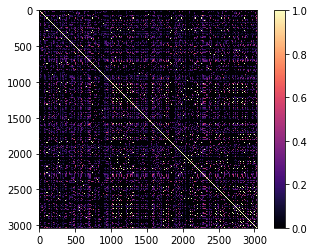

None


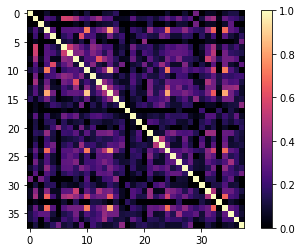

None


In [8]:
#Similarity heatmap of diseases and genes
Diseases = plot_heatmap(PD)
print(Diseases)
Genes = plot_heatmap(PG)
print(Genes)


In [9]:
def plot_Marginal(a):
    A = a.values
    x = A[:,0]
    y = A[:,1]
    sns.jointplot(x, y, kind='scatter')
    #plt.savefig('/Users/ravinschmidl/Desktop/Scatter_Plot_PD.png', dpi = 600)
    plt.show()

/Users/ravinschmidl/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


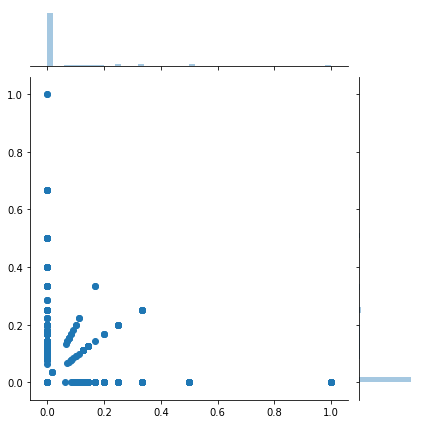

None


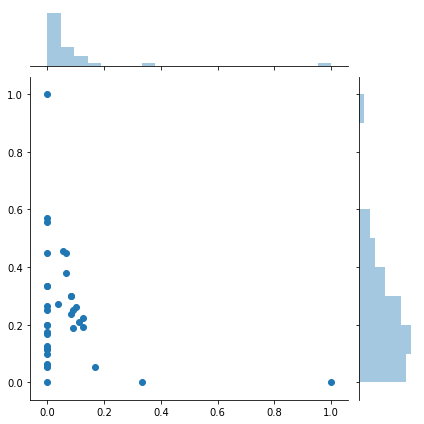

None


In [10]:
#Distribution of Data
DM = plot_Marginal(PD)
print(DM)
GM = plot_Marginal(PG)
print(GM)


# Clustering I

### Diseases and Gene Clustering

In [11]:
DZ = linkage(PD, method = 'complete')
GZ = linkage(PG, method = 'complete')


In [12]:
def create_Cluster(Z, X, a, b, thresh):
    plt.figure(figsize=(a, b)) #For Diseases
#     plt.figure(figsize=(30, 20)) #For Genes
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,
        labels = X.index.values,# font size for the x axis labels
#         color_threshold= thresh
    )

#     plt.savefig('/Users/ravinschmidl/Desktop/Test.svg')
    plt.show()

In [13]:
#Disease Clusters
create_Cluster(DZ, PD, 400, 75, 0.53) 
#fig size = 350,75
#saved as an svg

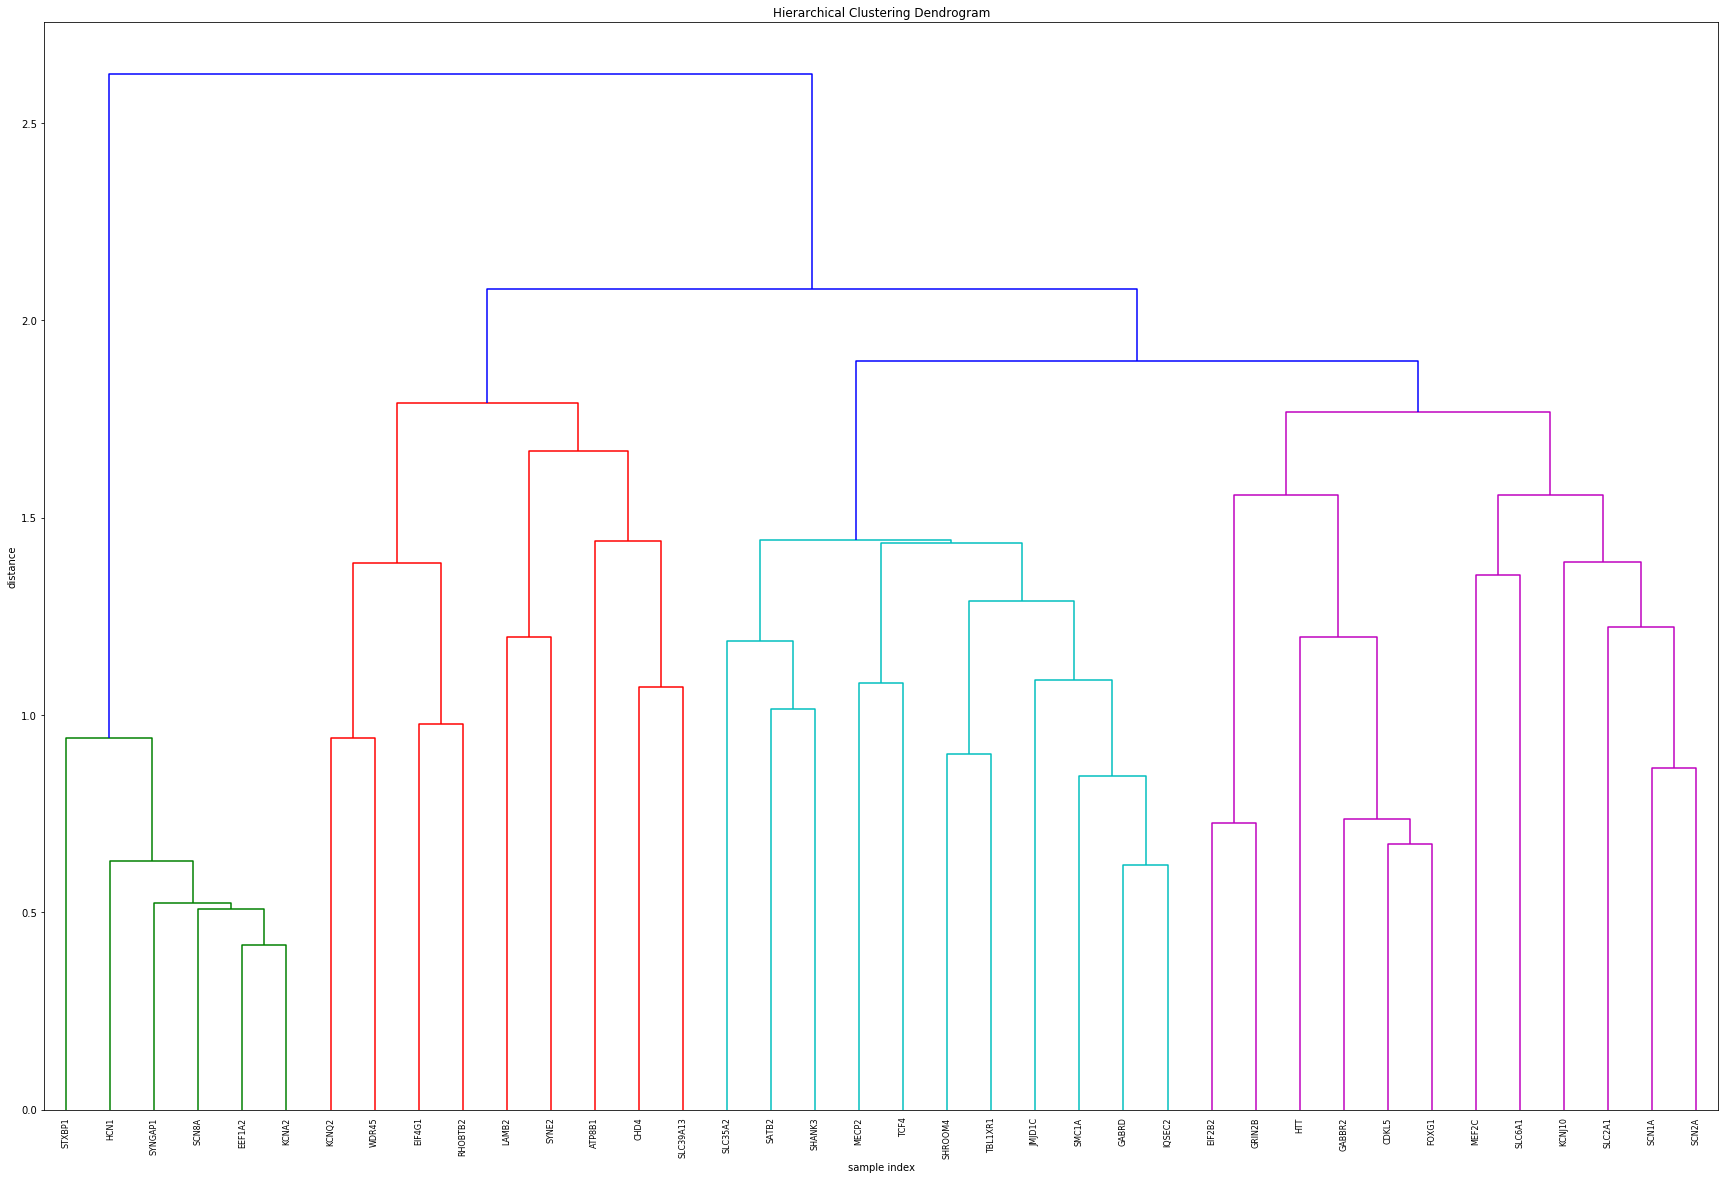

In [14]:
#Gene Clusters
create_Cluster(GZ, PG, 30, 20, 1.083)

# Phenotype Similarity

In [15]:
# Create Adjancy matrix of phenotypes to diseases
Pheno_D = pd.crosstab(PDA['HPO_ID'], PDA['UMLS'])
Pheno_D

#Create Adjacency matrix of phenotypes to genes
Pheno_G = pd.crosstab(Pg['HPO_ID'], Pg['Gene_Symbol'])
Pheno_G

Gene_Symbol,ATP8B1,CDKL5,CHD4,EEF1A2,EIF2B2,EIF4G1,FOXG1,GABBR2,GABRD,GRIN2B,...,SLC35A2,SLC39A13,SLC6A1,SMC1A,STXBP1,SYNE2,SYNGAP1,TBL1XR1,TCF4,WDR45
HPO_ID,,,,,,,,,,,,,,,,,,,,,
HP:0000164,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HP:0000252,0,1,0,1,0,0,1,1,1,0,...,1,0,0,1,1,0,1,1,1,0
HP:0000400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
HP:0000716,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
HP:0000717,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,1,0,1,0,0,0
HP:0000726,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
HP:0000729,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
HP:0000733,0,1,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
HP:0001063,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [16]:
#Identify phenotypes that need to be clusters
#Create Similarity matrix of phenotypes based on each disease(column)
PAP = Pheno_D

i=1
j=1
#Initialise the dataframe to calculate MCA, Resnik and Lin Similarity
B = pd.DataFrame()
b1 = []
b2 = []

#Construct a for loop to iterate through Adjacency Matrix of PDA
for i in range(0, len(PAP)):
    for j in range(0, len(PAP.columns)):
        if PAP.iloc[i-1,j] == 1: #If there is a PDA
            if int(PAP.iloc[i-1,j]) == int(PAP.iloc[i,j]): #If the Phenotype above has the sa
                #print("Term 1:")
                #print(PA.iloc[[i],j])
                #term_1 = str(PA.iloc[[i],j])
                x = str(PAP.iloc[[i-1],j]) 
                b1.append(x)
                B1 = pd.Series(b1)
                #print("Term 2: ")
                #print(PA.iloc[[i+1], j])
                #print(term1)
                y = str(PAP.iloc[[i], j])
                b2.append(y)
                B2 = pd.Series(b2)
                
                #term_2 = str(PA.iloc[[i+1], j])
                #Store Term 1 in column 1 and term 2 in column 2
                #B['term_1'] = B.append[B1] 
                #B['term_1', 'term_2'] = [term_1, term_2]
                #print(term1)
                #Calculate similarity
                #print("---------")

#What we have now in B1 and B2 are the two phenotypes that need to be compared. 
#The phenotypes were stored with their diseases, and both B1 and B2 are labeled with the disease
#We can use the disease as an ID for the two phenotype terms to be compared 
#These are then stored into a new dataframe.
#Subsequently, all of the MCA's of each pair must be determined and input into the DataFrame as new column..
#Using the MCA, the Resnik measure and Lin Measure can thus be deduced and these are also input into the dataframe. 
#Finally, for each disease, a similarity matrix (should be symmetric) of phenotypes will be constructed and.. 
#both similarity measures will be input into the matrix. 
#Hierarchical clustering will be conducted on the phenotypes


#Split text into different columns in B1
B_1 = B1.str.split(pat = '\n', expand = True)
B_1 = B_1.drop([0], axis = 1)
#Removing Unwanted text from data
HPOID_1 = B_1[1].str.replace(' 1','')
UMLS_1 = B_1[2].str.replace('Name: ','')
UMLS_1 = UMLS_1.str.replace(', dtype: int64','')
#Storing Term 1 UMLS and HPOID
B1 = pd.DataFrame(columns = ['UMLS', 'HPO_ID'])
B1['UMLS'] = UMLS_1
B1['HPO_ID'] = HPOID_1

#Split text into different columns in B2
B_2 = B2.str.split(pat = '\n', expand = True)
B_2 = B_2.drop([0], axis = 1)
#Removing Unwanted text from data
HPOID_2 = B_1[1].str.replace(' 1','')
UMLS_2 = B_1[2].str.replace('Name: ','')
UMLS_2 = UMLS_2.str.replace(', dtype: int64','')
#Storing Term 2 UMLS and HPOID
B2 = pd.DataFrame(columns = ['UMLS', 'HPO_ID'])
B2['UMLS'] = UMLS_2
B2['HPO_ID'] = HPOID_2

#Creating Term Comparison DataFrame
#This will be the skeleton for the similarity matrix
#Similarity matrix is constructed for all rows that have the same UMLS 
#where rows and columns are the unique HPOID's and the values in them are the similarity..
#measures calculated
B = pd.merge(B1, B2, on= ['UMLS'])
B = B.rename(index=str, columns={'HPO_ID_x': 'Term_1', 'HPO_ID_y': 'Term_2'})
B['Key'] = np.arange(len(B))
B

,UMLS,Term_1,Term_2,Key
0,C0035372,HP:0100716,HP:0100716,0
1,C0035372,HP:0100716,HP:0000164,1
2,C0035372,HP:0100716,HP:0000252,2
3,C0035372,HP:0100716,HP:0000400,3
4,C0035372,HP:0100716,HP:0000716,4
5,C0035372,HP:0100716,HP:0000717,5
6,C0035372,HP:0100716,HP:0000726,6
7,C0035372,HP:0100716,HP:0000729,7
8,C0035372,HP:0100716,HP:0000733,8
9,C0035372,HP:0100716,HP:0001063,9


### Determine Most Common Ancestors (MCA)

In [17]:
#Find MCA
#uses obonet and networkx
url = 'http://purl.obolibrary.org/obo/hp.obo'
graph = obo.read_obo(url)

In [18]:
#Get Descendents for each 
#nx.descendants returns a set
# we can use set(x) & set(y) to get the common values

def get_common_ancestors(Term1, Term2):
    MCA = []
    for i in range (0, len(Term1)):
        #Terms to be compared
        T1 = Term1[i]
        T2 = Term2[i] 
        #MCA Term1
        x = nx.descendants(graph, T1)
        y = nx.descendants(graph, T2)
        #Append all of the 
        #intersections in each set of ancestors
        z = set(x) & set (y)
        MCA.append(z)
    return MCA
return None

In [19]:
Term1 = pd.Series(B['Term_1'])
Term1 = Term1.str.replace('   ','')
Term1 = Term1.tolist()
Term2 = pd.Series(B['Term_2'])
Term2 = Term2.str.replace('   ','')
Term2 = Term2.tolist()

In [20]:
List1 = get_common_ancestors(Term1, Term2)
len(List1)

14077

In [21]:
#Since we want the most common ancestor we want to keep the last value in each set of each row
#So we store the ancestors in order in a list and append the last value of this list to a new list 
#Which is MCAS
sorted(List1[7])
MCAS = []
key = []
k = 0
for i in range(len(List1)):
    List = sorted(List1[i])
    MCAS.append(List[-1])
    key.append(k)
    k = k+1



In [22]:
MCAS

['HP:0100851',
 'HP:0000118',
 'HP:0000707',
 'HP:0000118',
 'HP:0012638',
 'HP:0012638',
 'HP:0012638',
 'HP:0012638',
 'HP:0012638',
 'HP:0000118',
 'HP:0000118',
 'HP:0012638',
 'HP:0012638',
 'HP:0012638',
 'HP:0000118',
 'HP:0012638',
 'HP:0000118',
 'HP:0000001',
 'HP:0000118',
 'HP:0000118',
 'HP:0000118',
 'HP:0000118',
 'HP:0000118',
 'HP:0012638',
 'HP:0012638',
 'HP:0000118',
 'HP:0000707',
 'HP:0012638',
 'HP:0012638',
 'HP:0000118',
 'HP:0000707',
 'HP:0012638',
 'HP:0012638',
 'HP:0012638',
 'HP:0012638',
 'HP:0012638',
 'HP:0000118',
 'HP:0000118',
 'HP:0000118',
 'HP:0000118',
 'HP:0000118',
 'HP:0012638',
 'HP:0000118',
 'HP:0000118',
 'HP:0000118',
 'HP:0012638',
 'HP:0000118',
 'HP:0000118',
 'HP:0000118',
 'HP:0000707',
 'HP:0000118',
 'HP:0012638',
 'HP:0012638',
 'HP:0000118',
 'HP:0000118',
 'HP:0000118',
 'HP:0031816',
 'HP:0000234',
 'HP:0000118',
 'HP:0000118',
 'HP:0000118',
 'HP:0000118',
 'HP:0000118',
 'HP:0000118',
 'HP:0000118',
 'HP:0000118',
 'HP:00001

In [23]:
mcas = pd.DataFrame()
mcas['Key'] = key
mcas['MCAS'] = MCAS

#Remove root term and it's child
Data = pd.merge(B, mcas, on=['Key'])
indexNames1 = Data[Data['MCAS'] == 'HP:0000118'].index #Child of root term
indexNames2 = Data[Data['MCAS'] == 'HP:0000001'].index #Root term
# Delete these row indexes from dataFrame
Data.drop(indexNames1, inplace=True)
Data.drop(indexNames2, inplace=True)


#J.to_csv(r'/Users/ravinschmidl/Desktop/x.csv')

def information_Content(X):
    #-log(P(term))
    #P(term) = number of times term appears / number of terms          
    Counts = X.value_counts()
    
    IC = []
    for i in range(0,len(Counts)):
        c = Counts[i]
        l = len(X)
        ic = -(math.log10(c/l))
        IC.append(ic)
        #print(IC)
        
    
    Info_content = Counts.reset_index()
    Info_content['IC'] = IC
    
    return(Info_content)


In [24]:
Names = pd.DataFrame()
Names['names']= PDA['phenotypeName']
Names['HPO_ID'] = PDA['HPO_ID']
Names

,names,HPO_ID
0,Acrocyanosis,HP:0001063
1,Acrocyanosis,HP:0001063
2,Acrocyanosis,HP:0001063
3,Acrocyanosis,HP:0001063
4,Acrocyanosis,HP:0001063
5,Acrocyanosis,HP:0001063
6,Acrocyanosis,HP:0001063
7,Acrocyanosis,HP:0001063
8,Acrocyanosis,HP:0001063
9,Acrocyanosis,HP:0001063


### Determine Similarity Between Phenotypes

In [25]:
print("=============================")
IC_MCAS = information_Content(Data['MCAS'])
print("Information Content for MCAS (Resnik Measure)")
print(IC_MCAS)

print("=============================")
IC_T1 = information_Content(Data['Term_1'])
print("Information Content for Term 1")
print(IC_T1)

print("=============================")
IC_T2 = information_Content(Data['Term_2'])
print("Information Content for Term 2")
print(IC_T2)
print("=============================")

Information Content for MCAS (Resnik Measure)
         index  MCAS        IC
0   HP:0012638  2801  0.250352
1   HP:0000707   796  0.796752
2   HP:0011842   318  1.195238
3   HP:0100547   117  1.629479
4   HP:0040068   107  1.668281
5   HP:0100022    91  1.738624
6   HP:0011804    62  1.905273
7   HP:0025032    56  1.949477
8   HP:0012759    55  1.957302
9   HP:0003011    52  1.981662
10  HP:0040064    51  1.990095
11  HP:0002795    43  2.064197
12  HP:0000234    36  2.141363
13  HP:0031816    35  2.153597
14  HP:0011805    31  2.206303
15  HP:0004325    29  2.235267
16  HP:0012639    28  2.250507
17  HP:0001510    27  2.266301
18  HP:0031703    21  2.375446
19  HP:0040070    21  2.375446
20  HP:0100543    21  2.375446
21  HP:0030956    20  2.396635
22  HP:0001507    18  2.442393
23  HP:0025031    16  2.493545
24  HP:0500015    16  2.493545
25  HP:0100261    16  2.493545
26  HP:0030178    12  2.618484
27  HP:0410042    12  2.618484
28  HP:0010985    12  2.618484
29  HP:0031466    12  2.

In [26]:
#Rename columns
IC_MCAS = IC_MCAS.drop(columns='MCAS')
IC_MCAS = IC_MCAS.rename(index=str, columns={"index": "MCAS", "IC": "Resnik"})
IC_MCAS

IC_T1 = IC_T1.drop(columns='Term_1')
IC_T1 = IC_T1.rename(index=str, columns={"index": "Term_1", "IC": "IC1"})
IC_T1

IC_T2 = IC_T2.drop(columns='Term_2')
IC_T2 = IC_T2.rename(index=str, columns={"index": "Term_2", "IC": "IC2"})
IC_T2

,Term_2,IC2
0,HP:0001250,1.011029
1,HP:0001251,1.156086
2,HP:0000252,1.277709
3,HP:0001257,1.308499
4,HP:0001332,1.493545
5,HP:0004209,1.507333
6,HP:0002376,1.524479
7,HP:0005484,1.560945
8,HP:0002066,1.600755
9,HP:0000716,1.607760


In [27]:

df1 = pd.merge(Data, IC_T1, on=['Term_1'])
df2 = pd.merge(df1, IC_T2, on=['Term_2'])
df3 = pd.merge(df2, IC_MCAS, on=['MCAS'])
df3

,UMLS,Term_1,Term_2,Key,MCAS,IC1,IC2,Resnik
0,C0035372,HP:0100716,HP:0100716,0,HP:0100851,1.648447,1.648447,2.852567
1,C0239849,HP:0100716,HP:0100716,3025,HP:0100851,1.648447,1.648447,2.852567
2,C0795864,HP:0100716,HP:0100716,3026,HP:0100851,1.648447,1.648447,2.852567
3,C1839332,HP:0100716,HP:0100716,3042,HP:0100851,1.648447,1.648447,2.852567
4,C1845055,HP:0100716,HP:0100716,6067,HP:0100851,1.648447,1.648447,2.852567
5,C2677682,HP:0100716,HP:0100716,6103,HP:0100851,1.648447,1.648447,2.852567
6,C2748910,HP:0100716,HP:0100716,9128,HP:0100851,1.648447,1.648447,2.852567
7,C0035372,HP:0000252,HP:0100716,110,HP:0000707,1.277709,1.648447,0.796752
8,C1839332,HP:0000252,HP:0100716,3152,HP:0000707,1.277709,1.648447,0.796752
9,C2677682,HP:0000252,HP:0100716,6213,HP:0000707,1.277709,1.648447,0.796752


In [28]:
def Lin(IC1, IC2, IC_MCA):
    num = 2*IC_MCA
    den = IC1 + IC2
    L = num/den
    return(L)

In [29]:
IC1 = df3['IC1']
IC2 = df3['IC2']
IC_MCA = df3['Resnik']
LM = []
for i in range(0, len(IC1)):
    ic1 = IC1[i]
    ic2 = IC2[i]
    icmca = IC_MCA[i]
    
    lin_measure = Lin(ic1, ic2, icmca)
    LM.append(lin_measure)
    

In [30]:
df3['Lin'] = LM
df3

,UMLS,Term_1,Term_2,Key,MCAS,IC1,IC2,Resnik,Lin
0,C0035372,HP:0100716,HP:0100716,0,HP:0100851,1.648447,1.648447,2.852567,1.730457
1,C0239849,HP:0100716,HP:0100716,3025,HP:0100851,1.648447,1.648447,2.852567,1.730457
2,C0795864,HP:0100716,HP:0100716,3026,HP:0100851,1.648447,1.648447,2.852567,1.730457
3,C1839332,HP:0100716,HP:0100716,3042,HP:0100851,1.648447,1.648447,2.852567,1.730457
4,C1845055,HP:0100716,HP:0100716,6067,HP:0100851,1.648447,1.648447,2.852567,1.730457
5,C2677682,HP:0100716,HP:0100716,6103,HP:0100851,1.648447,1.648447,2.852567,1.730457
6,C2748910,HP:0100716,HP:0100716,9128,HP:0100851,1.648447,1.648447,2.852567,1.730457
7,C0035372,HP:0000252,HP:0100716,110,HP:0000707,1.277709,1.648447,0.796752,0.544572
8,C1839332,HP:0000252,HP:0100716,3152,HP:0000707,1.277709,1.648447,0.796752,0.544572
9,C2677682,HP:0000252,HP:0100716,6213,HP:0000707,1.277709,1.648447,0.796752,0.544572


In [31]:
def Jiang_Conrath(IC1, IC2, IC_MCA):
    JC = 1-(IC1+IC2-2*IC_MCA)
    return(JC)

In [32]:
JC = []
for i in range(0, len(IC1)):
    ic1 = IC1[i]
    ic2 = IC2[i]
    icmca = IC_MCA[i]
    
    jc = Jiang_Conrath(ic1, ic2, icmca)
    JC.append(jc)


In [33]:
df3['JC'] = JC
# df3.sort_values(by=['UMLS'])

#Rett = df3[df3['UMLS'] == "C0035372"]
#Rett.to_csv(r'/Users/ravinschmidl/Desktop/Rett_Resnik_Lin_JC.csv')

Phenotype_Similarity = df3
Phenotype_Similarity

,UMLS,Term_1,Term_2,Key,MCAS,IC1,IC2,Resnik,Lin,JC
0,C0035372,HP:0100716,HP:0100716,0,HP:0100851,1.648447,1.648447,2.852567,1.730457,3.408240
1,C0239849,HP:0100716,HP:0100716,3025,HP:0100851,1.648447,1.648447,2.852567,1.730457,3.408240
2,C0795864,HP:0100716,HP:0100716,3026,HP:0100851,1.648447,1.648447,2.852567,1.730457,3.408240
3,C1839332,HP:0100716,HP:0100716,3042,HP:0100851,1.648447,1.648447,2.852567,1.730457,3.408240
4,C1845055,HP:0100716,HP:0100716,6067,HP:0100851,1.648447,1.648447,2.852567,1.730457,3.408240
5,C2677682,HP:0100716,HP:0100716,6103,HP:0100851,1.648447,1.648447,2.852567,1.730457,3.408240
6,C2748910,HP:0100716,HP:0100716,9128,HP:0100851,1.648447,1.648447,2.852567,1.730457,3.408240
7,C0035372,HP:0000252,HP:0100716,110,HP:0000707,1.277709,1.648447,0.796752,0.544572,-0.332652
8,C1839332,HP:0000252,HP:0100716,3152,HP:0000707,1.277709,1.648447,0.796752,0.544572,-0.332652
9,C2677682,HP:0000252,HP:0100716,6213,HP:0000707,1.277709,1.648447,0.796752,0.544572,-0.332652


##### Phenotype_Similarity is the final table with all of the similarity measures
##### Using the diseases/gene clusters, determine which diseases/genes are most similar to RTT/RTT genes, in order to reduce the amount of Data for clustering. Once the diseases/genes have been determined, remove all similarity measures of unwanted diseases/genes and create similarity matrix.
 

In [34]:
#all of the diseases clustered to be similar to RTT
UMLSa = ['C2748910', 'C2677682', 'C0035372', 'C1839332', 'C0405578', 
    'C0001206', 'C0271547', 'C0024408', 'C1868512', 'C3809609', 
    'C3554448', 'C3150924', 'C2675185', 'C2673630', 'C1846242', 
    'C1846175', 'C1838023', 'C0751436', 'C0031485', 'C0751435', 
    'C4014812', 'C3472711', 'C3810242', 'C1855733', 'C185448', 
    'C1853250', 'C1851943', 'C1851481', 'C1843891', 'C1837541', 
    'C1832585', 'C0751779', 'C0752123', 'C4015782', 'C4105781', 
    'C4015780', 'C4015619', 'C3807521', 'C3279885', 'C3160720', 
    'C2751536', 'C1863052', 'C1863051', 'C1854182', 'C1851958', 
    'C1850077', 'C1847650', 'C1847200', 'C1846862', 'C1839564', 
    'C1839564', 'C1838990', 'C1541844', 'C1306856', 'C0752347', 
    'C0338451', 'C00202578', 'C0002395', 'C3553250', 'C3715051', 
    'C2750460', 'C2720163', 'C2717836', 'C1860707', 'C1854465', 
    'C1854416', 'C0796275', 'C0079588', 'C0795888', 'C4225390', 
    'C4225242', 'C4082167', 'C4045991', 'C4015542', 'C4015214', 
    'C4014869', 'C3809929' 'C3808940', 'C3808920', 'C3715199', 
    'C3694531', 'C3661525', 'C3554540', 'C3552634', 'C3279561', 
    'C3278664', 'C3161174', 'C3151421', 'C3150354', 'C3149378', 
    'C2931048', 'C2751643', 'C2748941', 'C2748536', 'C2748507', 
    'C2697310', 'C2674723', 'C2608083', 'C1866120', 'C1866119', 
    'C1865643', 'C1861455', 'C1858968', 'C1858558', 'C1856255', 
    'C1856245', 'C1856251', 'C1853392', 'C1847973', 'C1847720', 
    'C1845888', 'C1844376', 'C1843355', 'C1837028', 'C1833541', 
    'C1720863', 'C1720862', 'C1720860', 'C1720859', 'C1270779', 
    'C1527386', 'C1384600', 'C1334968', 'C1328840', 'C0856761', 
    'C0549463', 'C0524988', 'C0398689', 'C0392164', 'C0342895', 
    'C0342750', 'C0342749', 'C0333693', 'C0272203', 'C0272051', 
    'C0268601', 'C0268532', 'C0268389', 'C0268381', 'C0268314', 
    'C0221757', 'C0221032', 'C0221013', 'C0206702', 'C0206141', 
    'C0158945', 'C0085253', 'C0039292', 'C0036489', 'C0030328', 
    'C0026948', 'C0024314', 'C0022350', 'C0021071', 'C0020479', 
    'C0019621', 'C001954', 'C0018203', 'C0015773', 'C0011311', 
    'C0009447', 'C0008384', 'C0005411', 'C0002895', 'C0004903', 
    'C4225419', 'C4225303', 'C4225234', 'C4083048', 'C4015597', 
    'C4015349', 'C4014690', 'C3887645', 'C3809875', 'C3668942', 
    'C3553762', 'C3553660', 'C2552645', 'C3489795', 'C3276228', 
    'C3151087', 'C2150967', 'C2936739', 'C2936332', 'C2931355', 
    'C2752042', 'C2700406', 'C2676285', 'C1970211', 'C1868118', 
    'C1866636', 'C1866182', 'C1861689', 'C1859209','C1857344', 
    'C1854449', 'C1854106', 'C1853162', 'C1850386', 'C1849069', 
    'C1847800', 'C18456055', 'C1843225', 'C1842197', 'C1837552', 
    'C1836683', 'C1836336', 'C1836295', 'C1836133', 'C1833736', 
    'C1832399', 'C1832390', 'C1832274', 'C1527388', 'C1327918', 
    'C0559483', 'C0432225', 'C0410422', 'C0393807', 'C0268365', 
    'C0221054', 'C0220724', 'C0220692', 'C0152438', 'C0004779', 
    'C0038015', 'C0011989', 'C0795889', 'C0010314', 'C3275447', 
    'C0221060', 'C0152095', 'C0086650', 'C0086648', 'C0026706', 
    'C008647', 'C1968550', 'C1968551', 'C0265219', 'C1837396', 
    'C0812437', 'C3151519', 'C0751434', 'C3280203', 'C1850055', 
    'C1850056', 'C4225355', 'C0751491', 'C0751491', 'C0751489', 
    'C0751490', 'C1850598', 'C0023264', 'C1838951', 'C0023264', 
    'C1838951', 'C3541471', 'C1853564', 'C1833102', 'C1833104', 
    'C1848201', 'C1836727', 'C1848922', 'C1843366', 'C3179455', 
    'C0220756', 'C0268247', 'C0715587', 'C0022797', 'C0268281', 
    'C1850510', 'C0268281', 'C1850510', 'C0268228', 'C0023806', 
    'C0268226', 'C1855008', 'C0004135', 'C1876175', 'C0271742', 
    'C0398691', 'C0268272', 'C2718068', 'C0268579', 'C3809877', 
    'C1845861', 'C3658299', 'C0265240', 'C0796206', 'C1855772', 
    'C2931008', 'C1859878', 'C0037231', 'C0265338', 'C4225666',
    'C0376524', 'C2677613', 'C0432268', 'C0018553', 'C0391826',
    'C0795950', 'C1836929', 'C3809454', 'C3279800', 'C4225276', 
    'C0086431', 'C0268255', 'C2931187', 'C0751039', 'C0270972', 
    'C0175702', 'C1845055'
                    ]
CD = pd.DataFrame()
CD['UMLS'] = UMLSa
Clustered_Diseases_Similarities = pd.DataFrame()
Clustered_Diseases_Similarities = pd.merge(Phenotype_Similarity, CD, on=['UMLS'])
#Clustered_Diseases_Similarities.to_csv(r'/Users/ravinschmidl/Desktop/clustered.csv')

### #Generate similarity matrix based on Resnik, Lin and Jiang-Conrath measures

In [35]:
#Resnik
Phenos1 = pd.crosstab(Clustered_Diseases_Similarities['Term_1'], Clustered_Diseases_Similarities['Term_2'])
list_of_labels1 = Phenos1.index.tolist()
nb_labels1 = len(list_of_labels1)
similarity1 = np.zeros( (nb_labels1,nb_labels1) )

for l1, l2, val in zip( Clustered_Diseases_Similarities['Term_1'],
                       Clustered_Diseases_Similarities['Term_2'],
                       Clustered_Diseases_Similarities['Resnik'] ):
    i = list_of_labels1.index( l1 )
    j = list_of_labels1.index( l2 )
    similarity1[i][j] = val


ResnikD = pd.DataFrame(data=similarity1, index=list_of_labels1, columns=list_of_labels1, dtype = float)
ResnikD

,HP:0000164,HP:0000252,HP:0000400,HP:0000716,HP:0000717,HP:0000726,HP:0000729,HP:0000733,HP:0001063,HP:0001163,...,HP:0004879,HP:0005135,HP:0005184,HP:0005484,HP:0009738,HP:0010521,HP:0010864,HP:0011675,HP:0012742,HP:0100716
HP:0000164,2.153597,2.141363,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.141363,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HP:0000252,2.141363,1.629479,0.000000,0.796752,0.796752,0.796752,0.796752,0.796752,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.629479,0.000000,0.796752,0.796752,0.000000,0.000000,0.796752
HP:0000400,0.000000,0.000000,2.375446,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.375446,0.000000,0.000000,0.000000,0.000000,0.000000
HP:0000716,0.000000,0.796752,0.000000,2.618484,0.250352,0.250352,0.250352,0.250352,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.796752,0.000000,0.250352,0.250352,0.000000,0.000000,0.250352
HP:0000717,0.000000,0.796752,0.000000,0.250352,0.250352,0.250352,0.250352,0.250352,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.796752,0.000000,0.250352,0.250352,0.000000,0.000000,0.250352
HP:0000726,0.000000,0.796752,0.000000,0.250352,0.250352,2.375446,0.250352,0.250352,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.796752,0.000000,0.250352,0.250352,0.000000,0.000000,0.250352
HP:0000729,0.000000,0.796752,0.000000,0.250352,0.250352,0.250352,0.250352,0.250352,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.796752,0.000000,0.250352,0.250352,0.000000,0.000000,0.250352
HP:0000733,0.000000,0.796752,0.000000,0.250352,0.250352,0.250352,0.250352,1.738624,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.796752,0.000000,1.738624,0.250352,0.000000,0.000000,0.250352
HP:0001063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.095605,0.000000,...,2.064197,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.794575,0.000000
HP:0001163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.375446,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [36]:
#Lin
Phenos2 = pd.crosstab(Clustered_Diseases_Similarities['Term_1'], Clustered_Diseases_Similarities['Term_2'])
list_of_labels2 = Phenos2.index.tolist()
nb_labels2 = len(list_of_labels2)
similarity2 = np.zeros( (nb_labels2,nb_labels2) )

for l3, l4, val2 in zip( Clustered_Diseases_Similarities['Term_1'],
                       Clustered_Diseases_Similarities['Term_2'],
                       Clustered_Diseases_Similarities['Lin'] ):
    i = list_of_labels2.index( l3 )
    j = list_of_labels2.index( l4 )
    similarity2[i][j] = val2


LinD = pd.DataFrame(data=similarity2, index=list_of_labels2, columns=list_of_labels2, dtype = float)
LinD

,HP:0000164,HP:0000252,HP:0000400,HP:0000716,HP:0000717,HP:0000726,HP:0000729,HP:0000733,HP:0001063,HP:0001163,...,HP:0004879,HP:0005135,HP:0005184,HP:0005484,HP:0009738,HP:0010521,HP:0010864,HP:0011675,HP:0012742,HP:0100716
HP:0000164,1.091319,1.317316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.211749,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HP:0000252,1.317316,1.275313,0.000000,0.552251,0.546717,0.543849,0.545292,0.541649,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.148065,0.000000,0.541649,0.546717,0.000000,0.000000,0.544572
HP:0000400,0.000000,0.000000,0.919389,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.883345,0.000000,0.000000,0.000000,0.000000,0.000000
HP:0000716,0.000000,0.552251,0.000000,1.628653,0.154313,0.153585,0.153952,0.153027,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.502888,0.000000,0.153027,0.154313,0.000000,0.000000,0.153769
HP:0000717,0.000000,0.546717,0.000000,0.154313,0.152937,0.152222,0.152581,0.151673,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.498295,0.000000,0.151673,0.152937,0.000000,0.000000,0.152402
HP:0000726,0.000000,0.543849,0.000000,0.153585,0.152222,1.437623,0.151870,0.150970,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.495911,0.000000,0.150970,0.152222,0.000000,0.000000,0.151692
HP:0000729,0.000000,0.545292,0.000000,0.153952,0.152581,0.151870,0.152228,0.151324,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.497111,0.000000,0.151324,0.152581,0.000000,0.000000,0.152049
HP:0000733,0.000000,0.541649,0.000000,0.153027,0.151673,0.150970,0.151324,1.044694,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.494081,0.000000,1.044694,0.151673,0.000000,0.000000,0.151147
HP:0001063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.241447,0.000000,...,0.807584,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.056926,0.000000
HP:0001163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.109315,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [37]:
#Jiang-Conrath
Phenos3 = pd.crosstab(Clustered_Diseases_Similarities['Term_1'], Clustered_Diseases_Similarities['Term_2'])
list_of_labels3 = Phenos3.index.tolist()
nb_labels3 = len(list_of_labels3)
similarity3 = np.zeros( (nb_labels3,nb_labels3) )

for l5, l6, val3 in zip( Clustered_Diseases_Similarities['Term_1'],
                       Clustered_Diseases_Similarities['Term_2'],
                       Clustered_Diseases_Similarities['Lin'] ):
    i = list_of_labels3.index( l5 )
    j = list_of_labels3.index( l6 )
    similarity3[i][j] = val3


JCD = pd.DataFrame(data=similarity3, index=list_of_labels3, columns=list_of_labels3, dtype = float)
JCD

,HP:0000164,HP:0000252,HP:0000400,HP:0000716,HP:0000717,HP:0000726,HP:0000729,HP:0000733,HP:0001063,HP:0001163,...,HP:0004879,HP:0005135,HP:0005184,HP:0005484,HP:0009738,HP:0010521,HP:0010864,HP:0011675,HP:0012742,HP:0100716
HP:0000164,1.091319,1.317316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.211749,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HP:0000252,1.317316,1.275313,0.000000,0.552251,0.546717,0.543849,0.545292,0.541649,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.148065,0.000000,0.541649,0.546717,0.000000,0.000000,0.544572
HP:0000400,0.000000,0.000000,0.919389,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.883345,0.000000,0.000000,0.000000,0.000000,0.000000
HP:0000716,0.000000,0.552251,0.000000,1.628653,0.154313,0.153585,0.153952,0.153027,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.502888,0.000000,0.153027,0.154313,0.000000,0.000000,0.153769
HP:0000717,0.000000,0.546717,0.000000,0.154313,0.152937,0.152222,0.152581,0.151673,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.498295,0.000000,0.151673,0.152937,0.000000,0.000000,0.152402
HP:0000726,0.000000,0.543849,0.000000,0.153585,0.152222,1.437623,0.151870,0.150970,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.495911,0.000000,0.150970,0.152222,0.000000,0.000000,0.151692
HP:0000729,0.000000,0.545292,0.000000,0.153952,0.152581,0.151870,0.152228,0.151324,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.497111,0.000000,0.151324,0.152581,0.000000,0.000000,0.152049
HP:0000733,0.000000,0.541649,0.000000,0.153027,0.151673,0.150970,0.151324,1.044694,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.494081,0.000000,1.044694,0.151673,0.000000,0.000000,0.151147
HP:0001063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.241447,0.000000,...,0.807584,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.056926,0.000000
HP:0001163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.109315,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


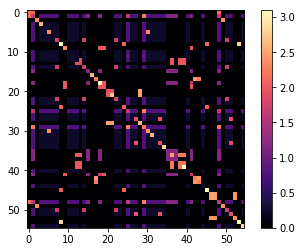

None


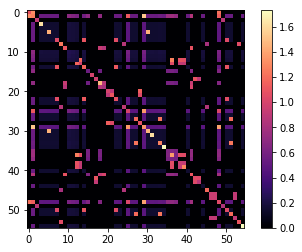

None


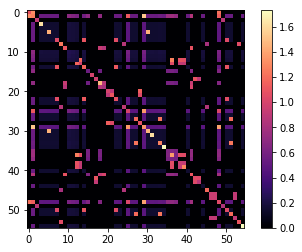

None


In [38]:
#Similarity heatmap of phenotypes to the diseases
RHD = plot_heatmap(ResnikD)
print(RHD)
LHD = plot_heatmap(LinD)
print(LHD)
JHD = plot_heatmap(JCD)
print(JHD)

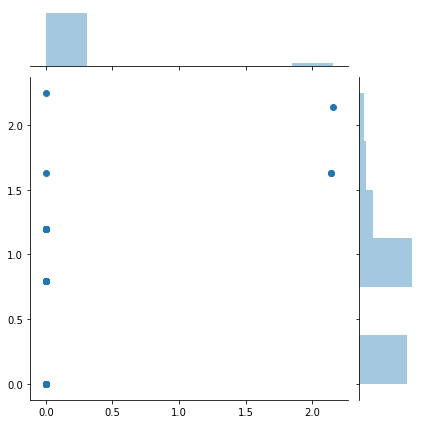

None


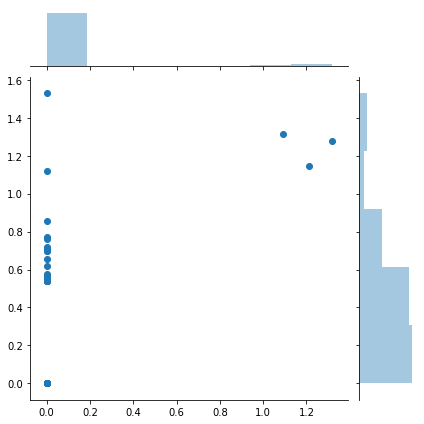

None


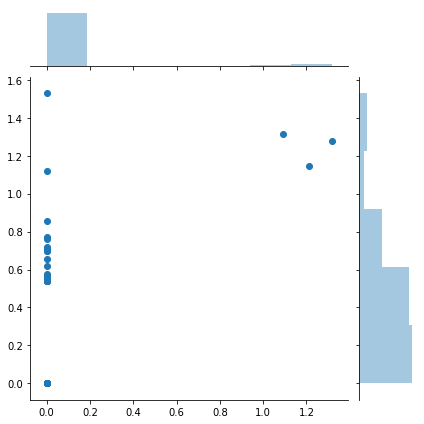

               HP:0000164     HP:0000252     HP:0000400     HP:0000716     \
HP:0000164          1.091319       1.317316       0.000000       0.000000   
HP:0000252          1.317316       1.275313       0.000000       0.552251   
HP:0000400          0.000000       0.000000       0.919389       0.000000   
HP:0000716          0.000000       0.552251       0.000000       1.628653   
HP:0000717          0.000000       0.546717       0.000000       0.154313   
HP:0000726          0.000000       0.543849       0.000000       0.153585   
HP:0000729          0.000000       0.545292       0.000000       0.153952   
HP:0000733          0.000000       0.541649       0.000000       0.153027   
HP:0001063          0.000000       0.000000       0.000000       0.000000   
HP:0001163          0.000000       0.000000       0.000000       0.000000   
HP:0001250          0.000000       0.696237       0.000000       0.191197   
HP:0001251          0.000000       0.654740       0.000000       0.181162   

In [39]:
RMD = plot_Marginal(ResnikD)
print(RMD)
LMD = plot_Marginal(LinD)
print(LMD)
JM = plot_Marginal(JCD)
print(JCD)

# Clustering II

In [40]:
RZ = linkage(ResnikD, method = 'complete')
LZ = linkage(LinD, method = 'complete')
JZ = linkage(JCD, method = 'complete')

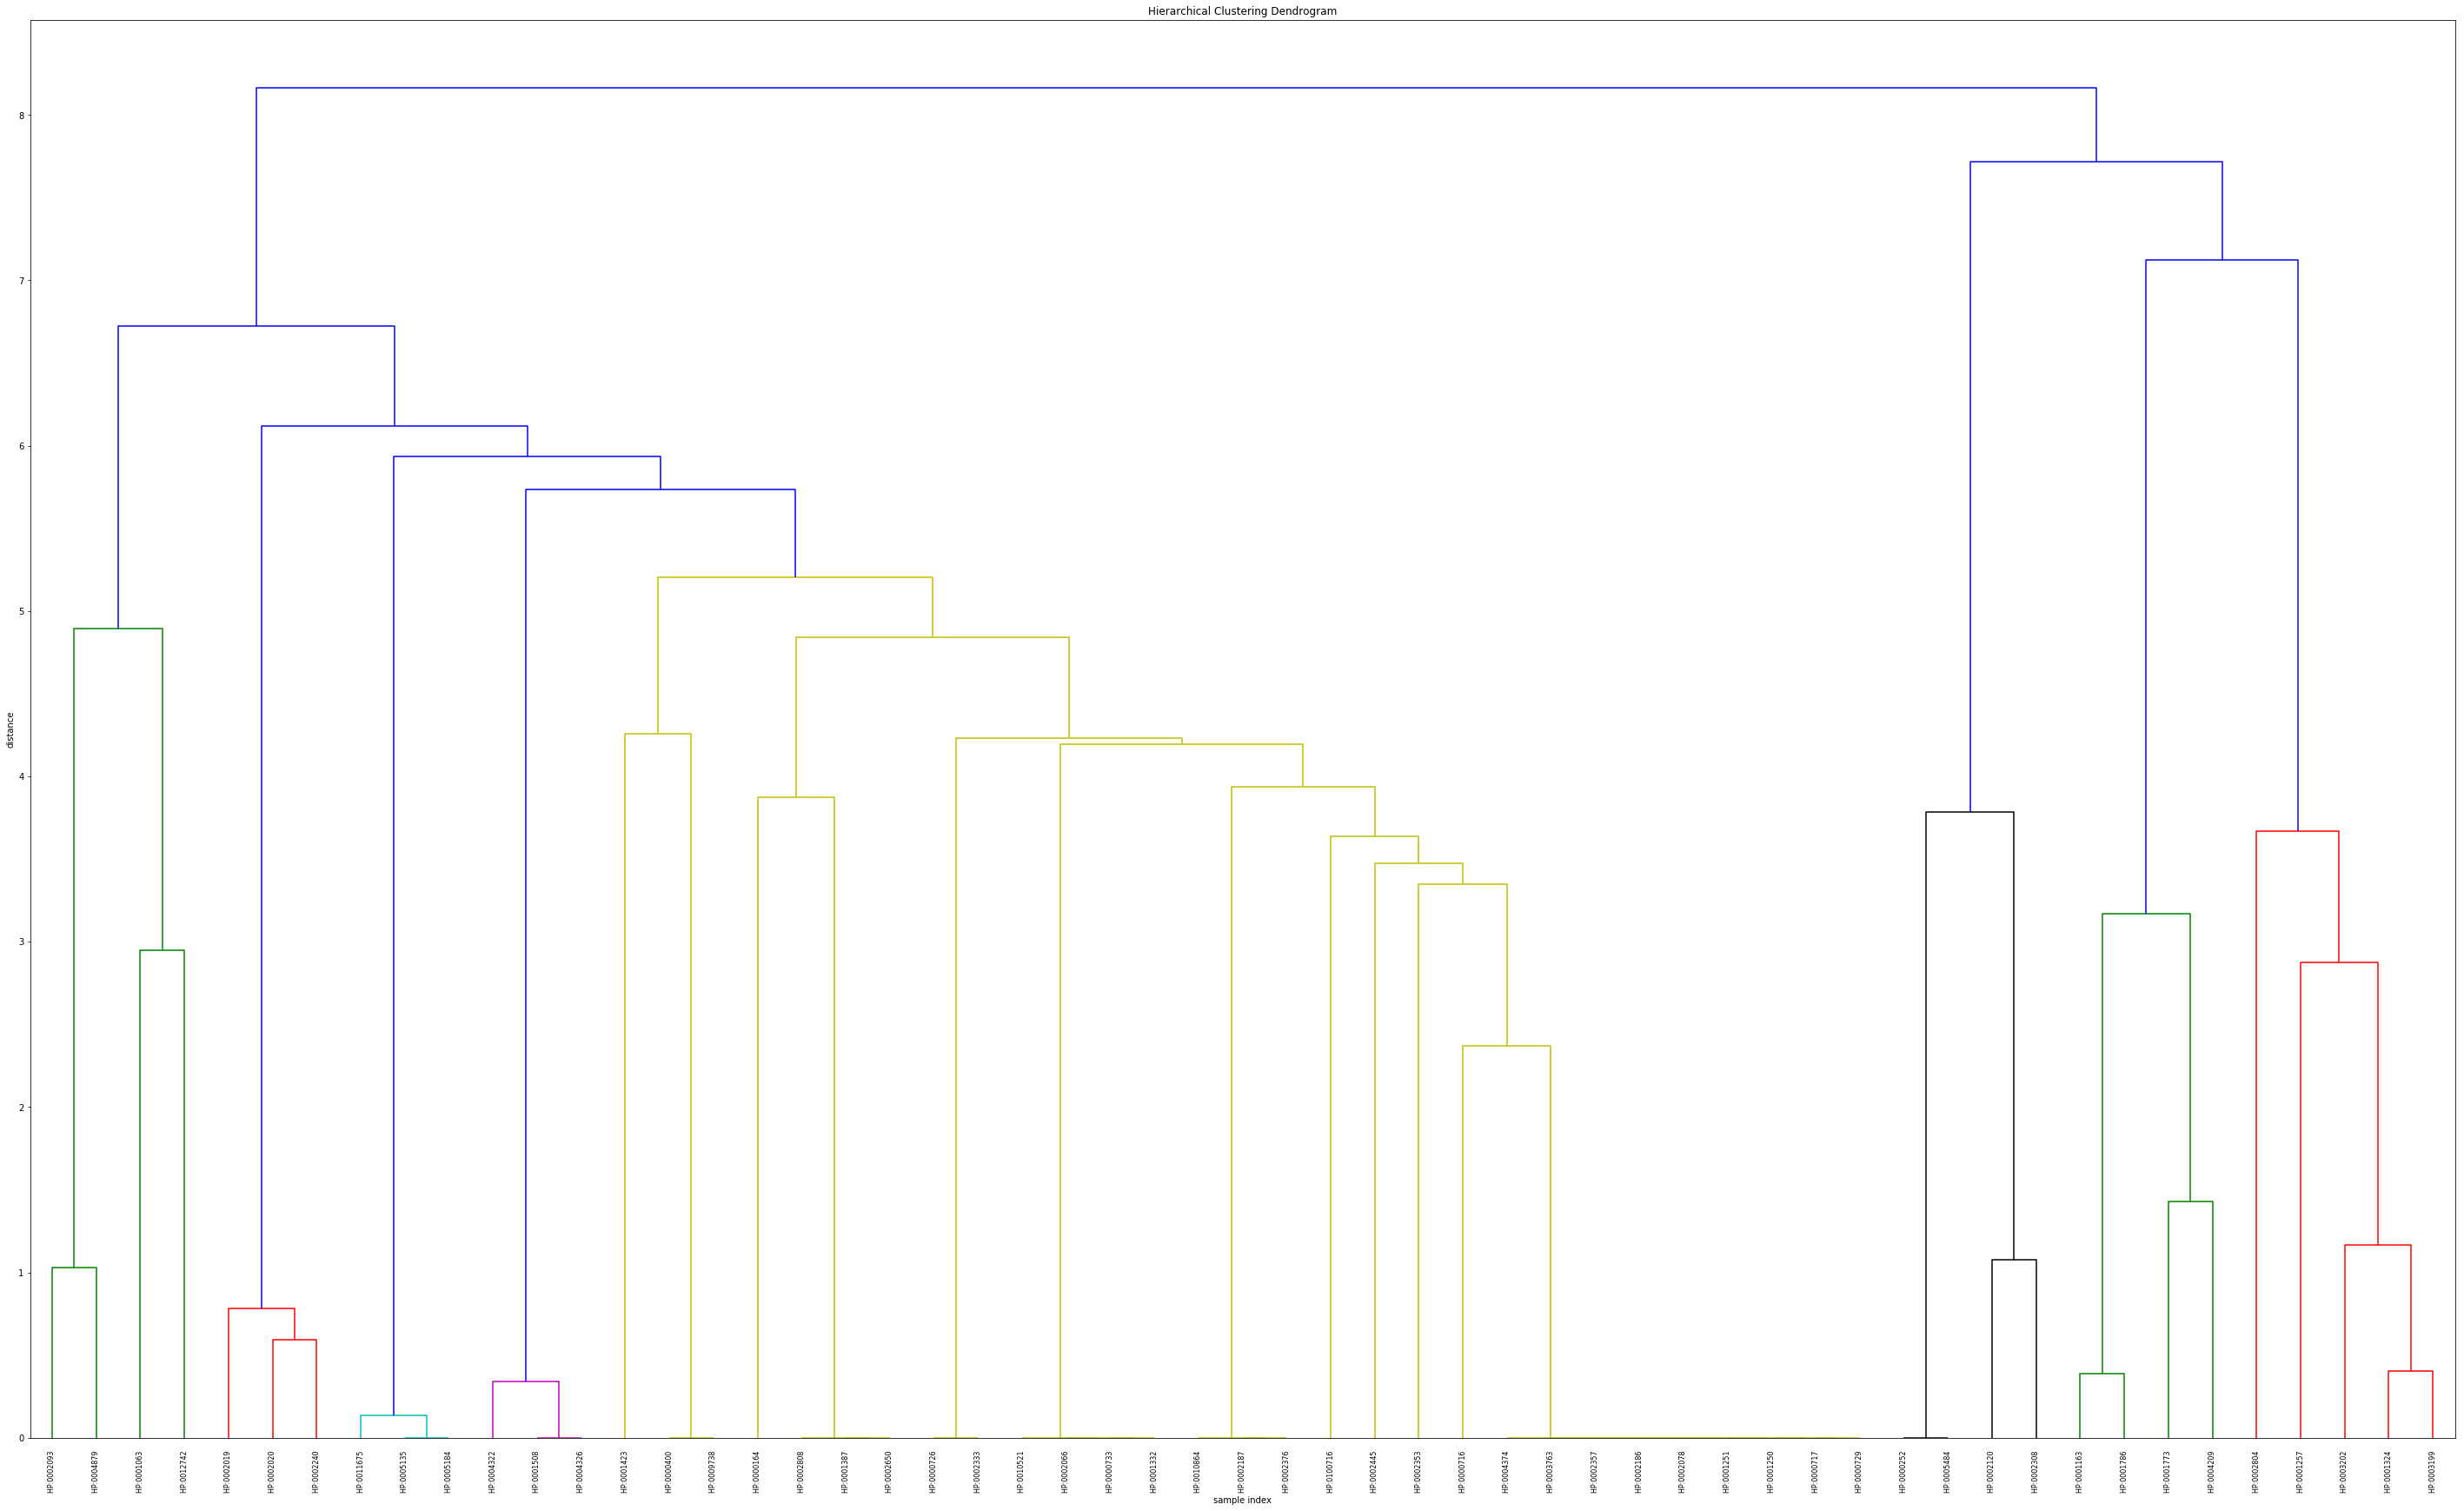

In [41]:
create_Cluster(RZ, ResnikD, 50, 30, 2.4)

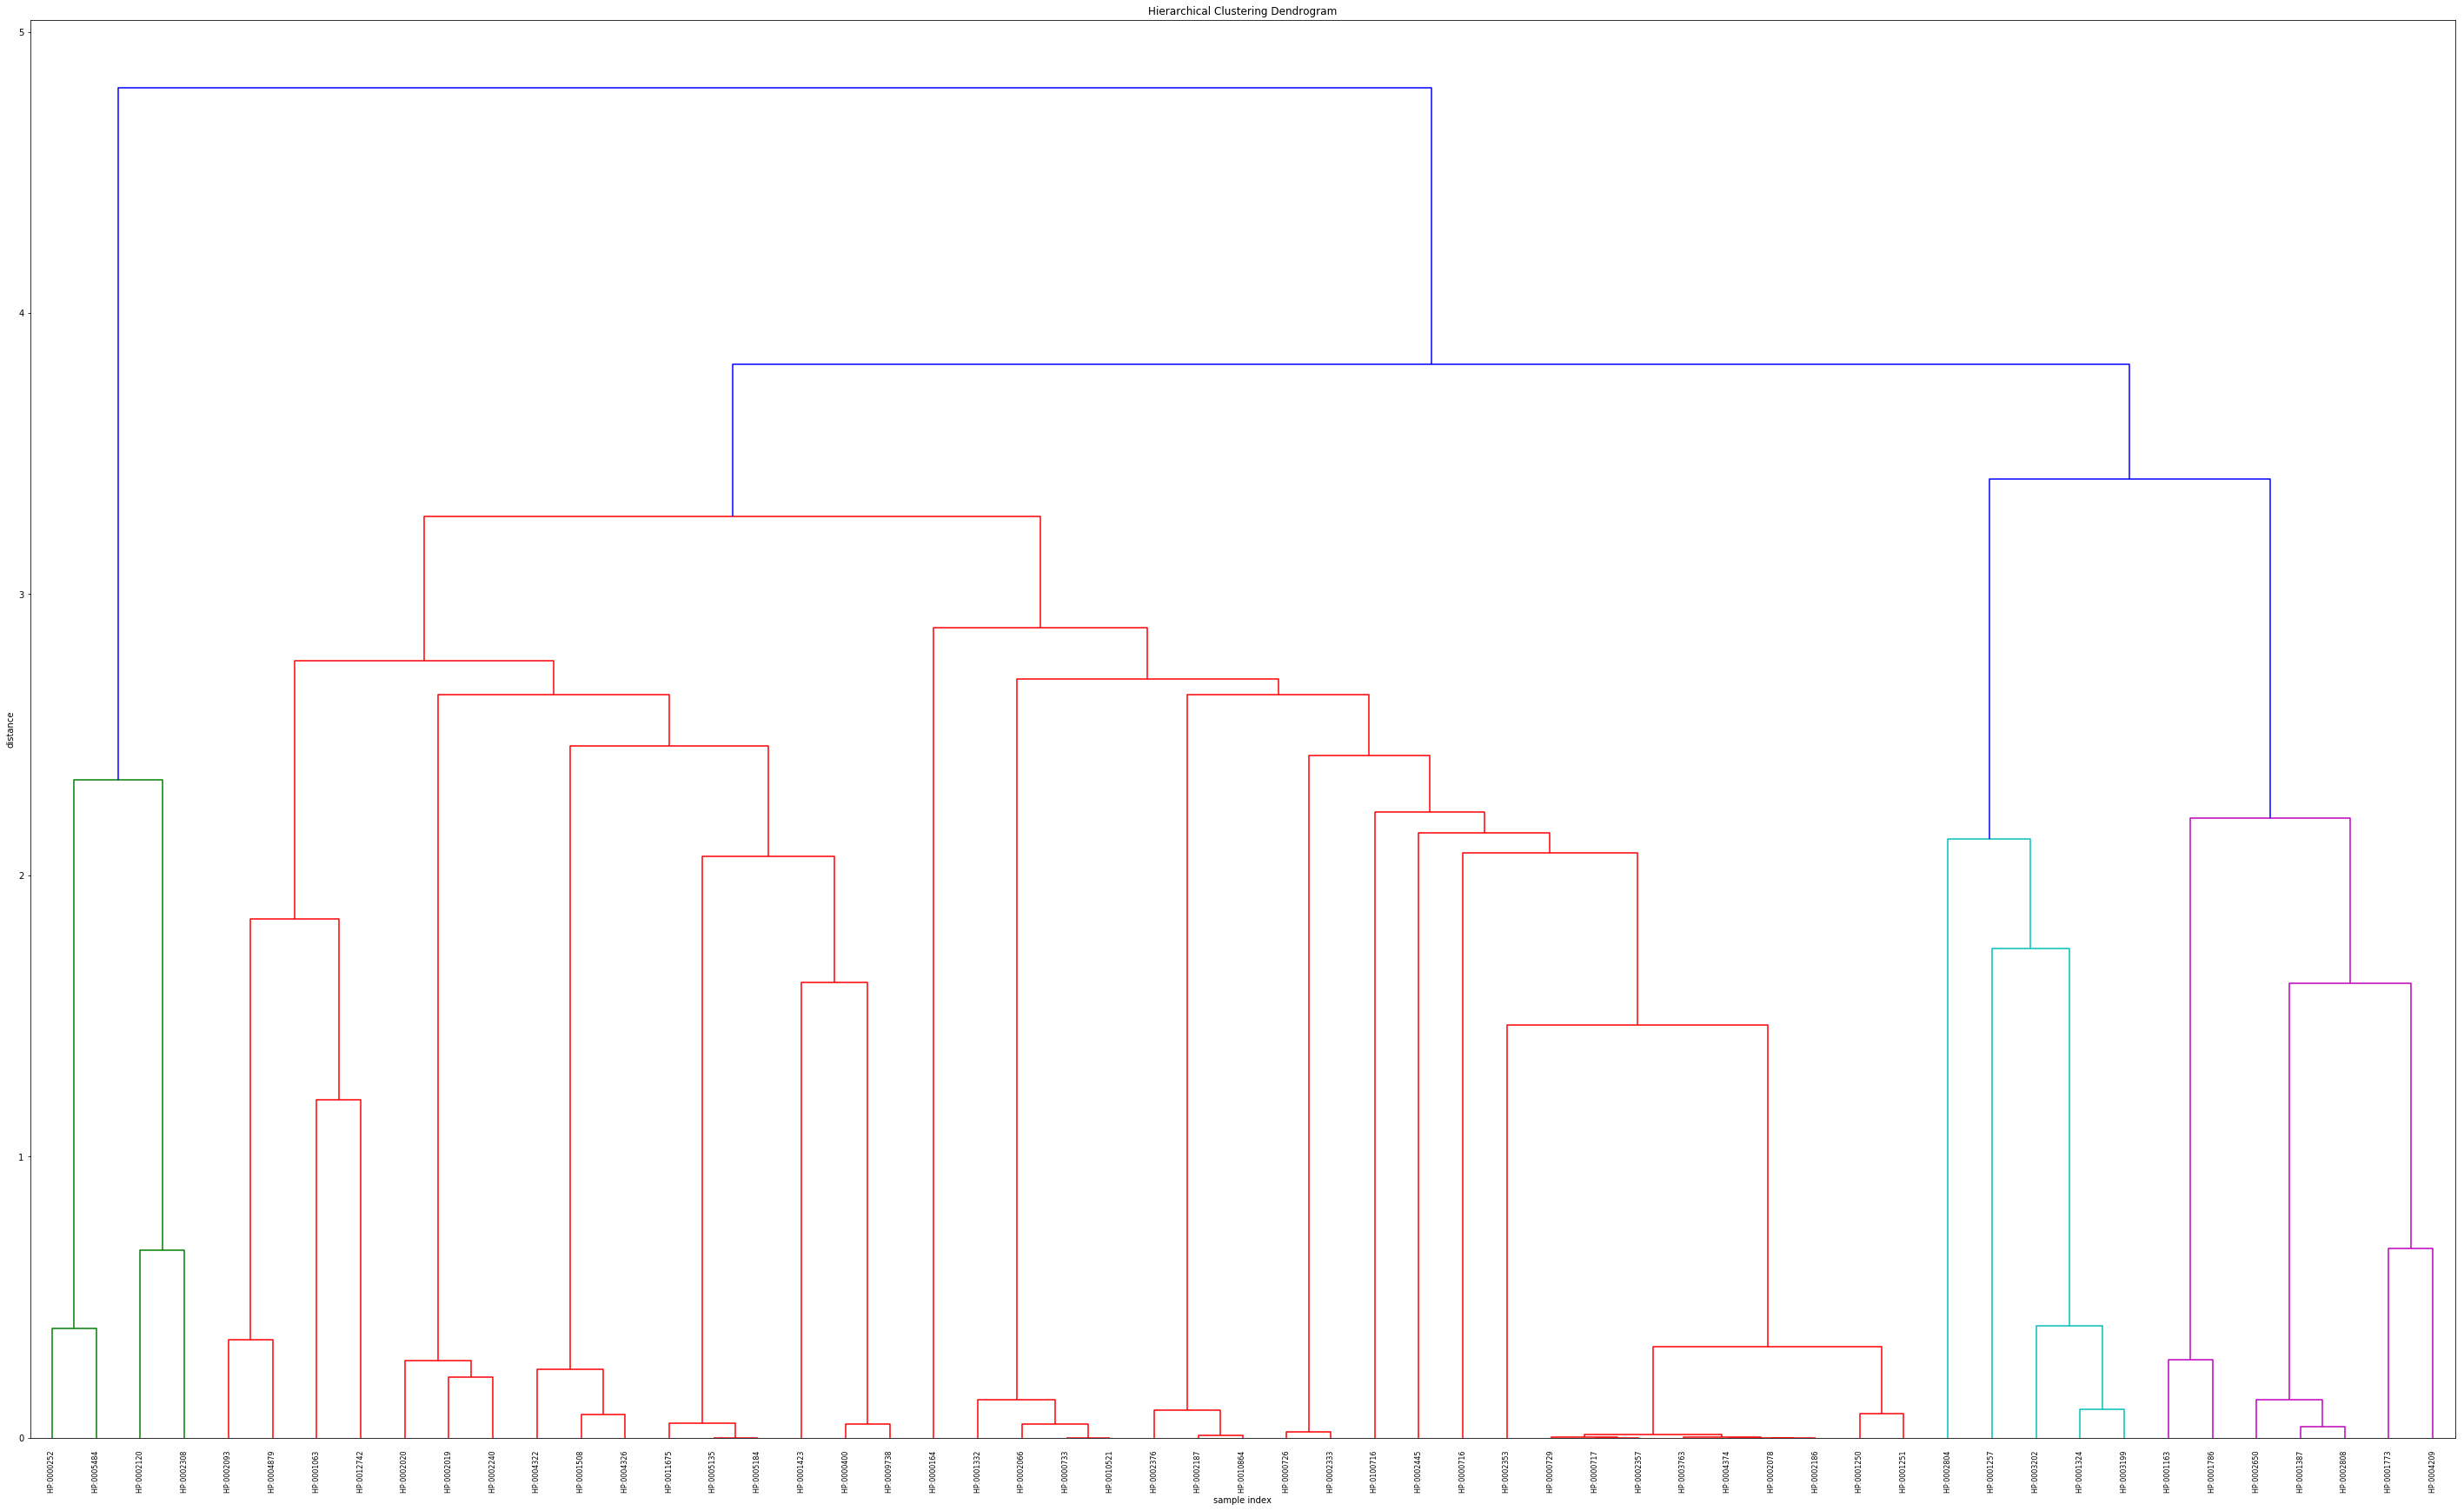

In [42]:
create_Cluster(LZ, LinD, 50, 30, 1.59)

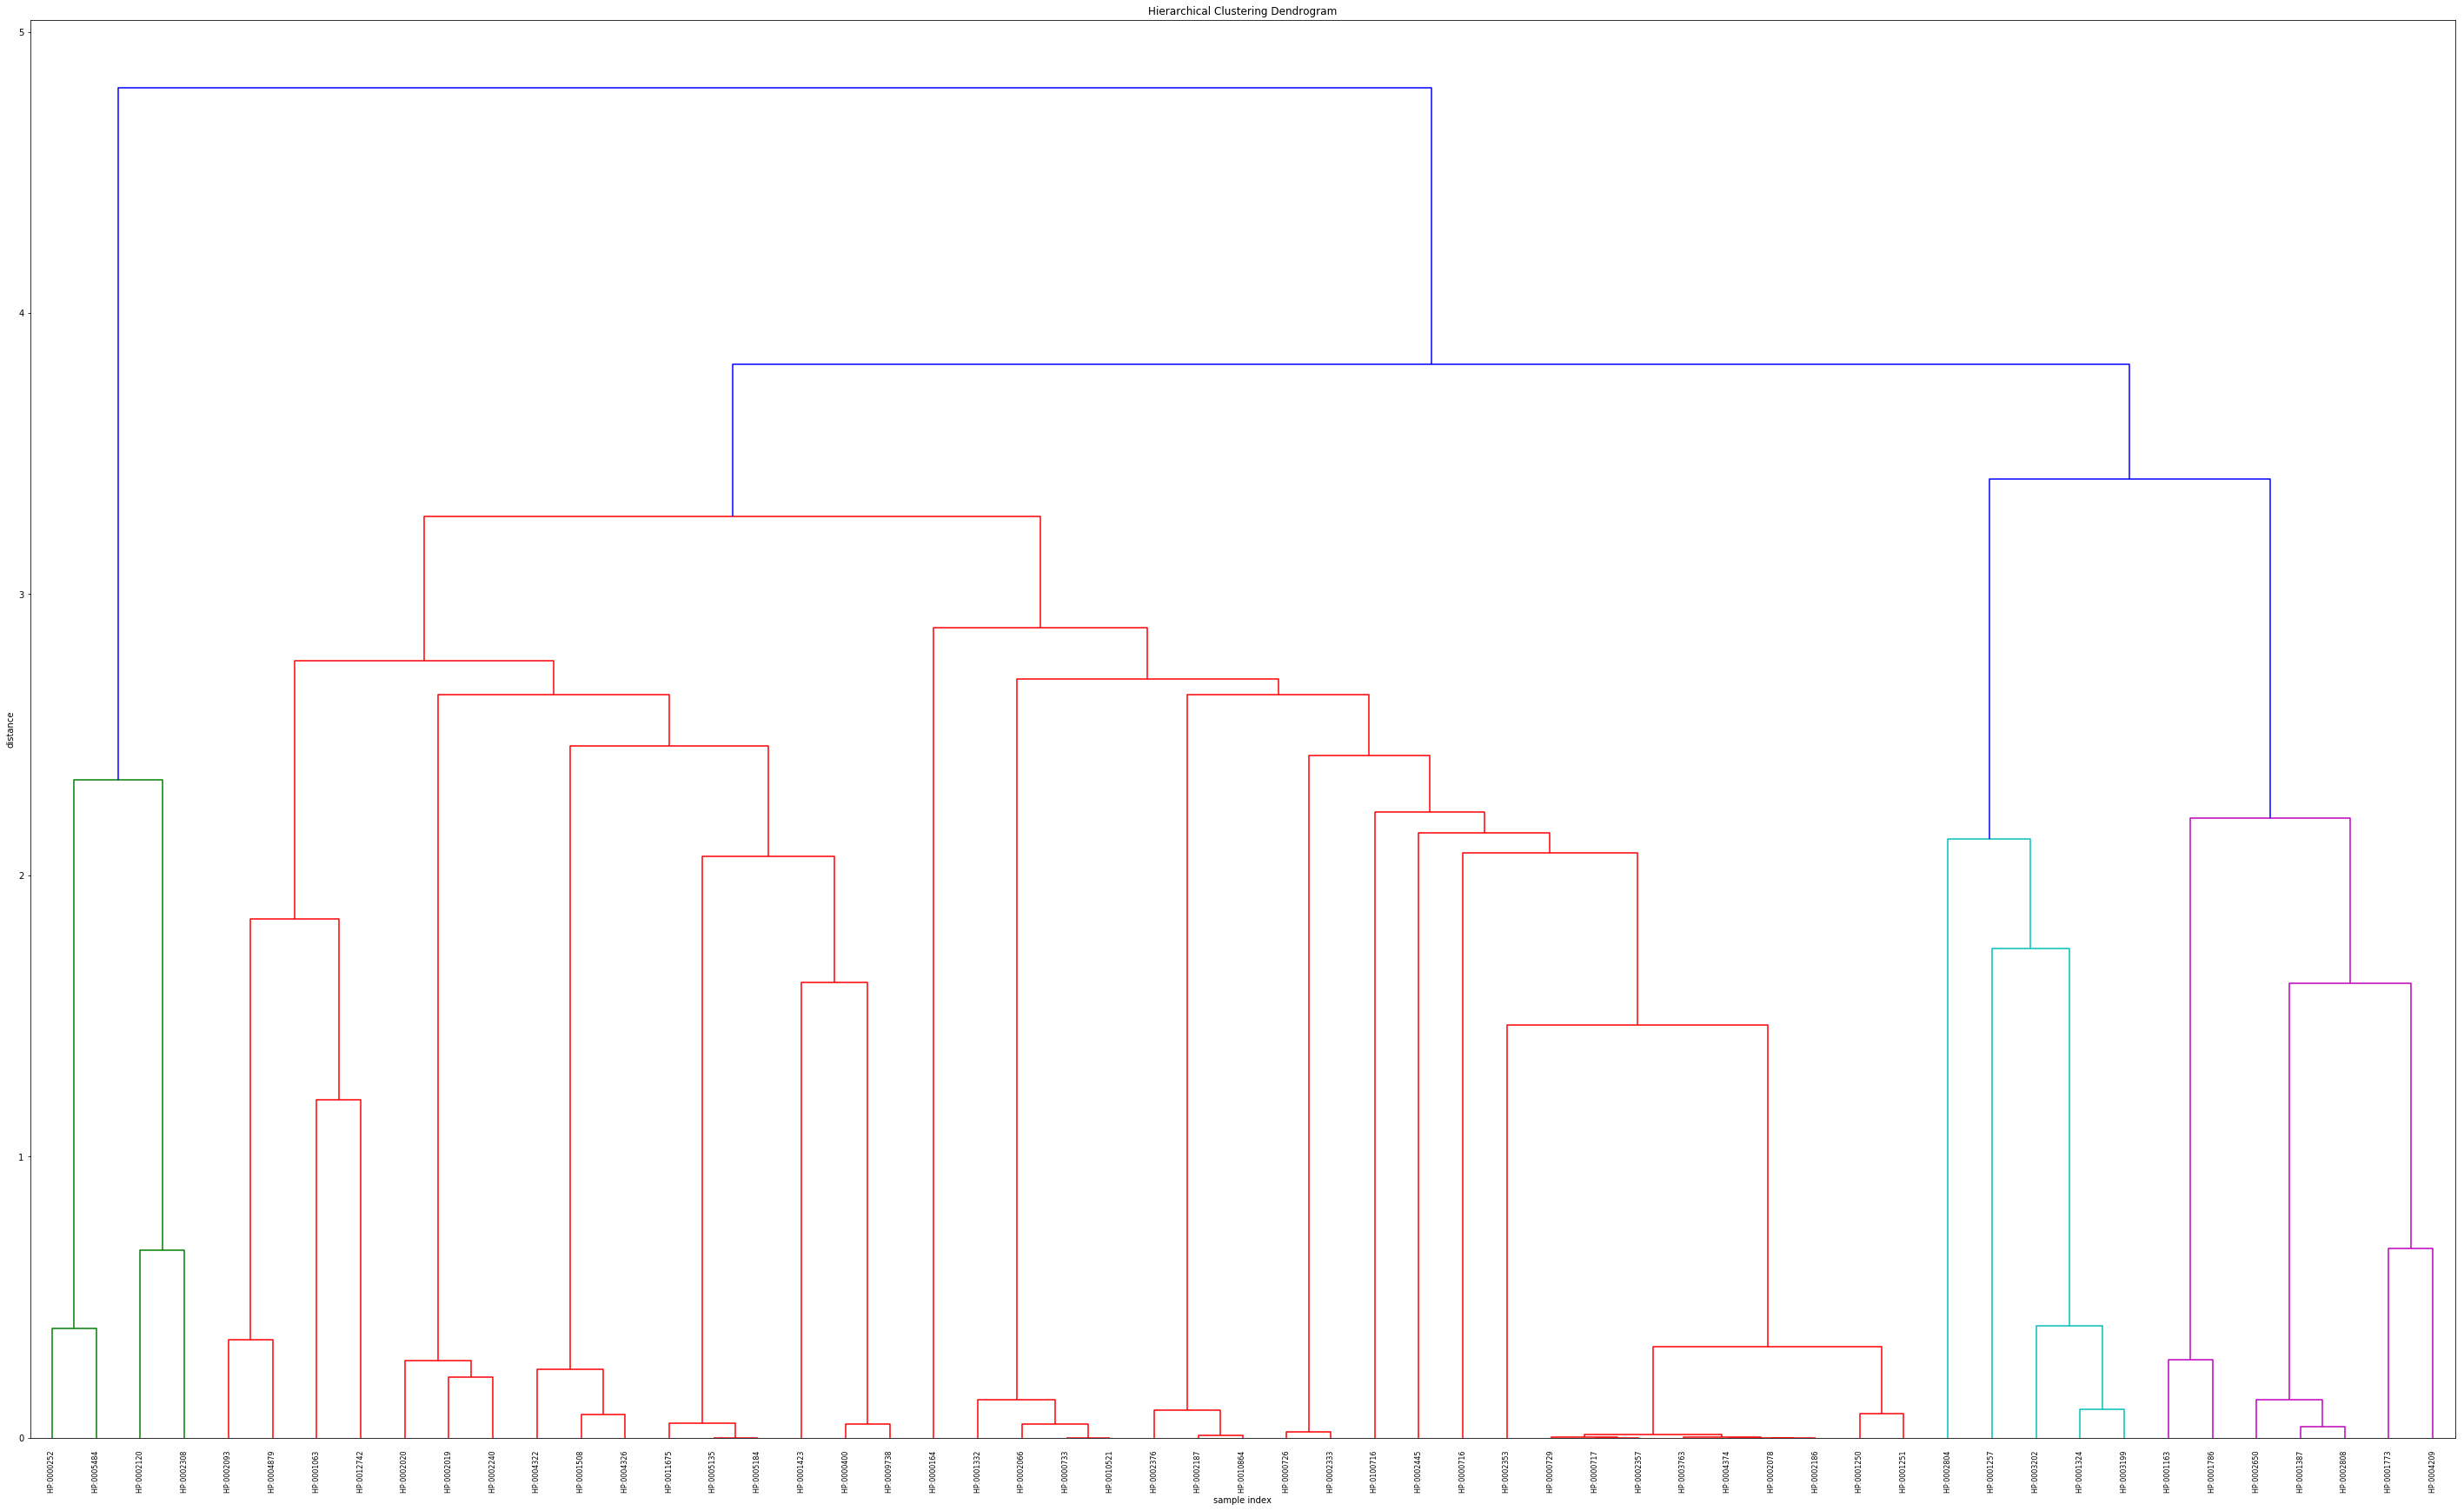

In [43]:
create_Cluster(JZ, JCD, 50, 30, 1.59)

In [44]:
#From the above graphs, when we draw a horizontal line between the two furthest vertical lines, 
#the number of intersections determines the number of clusters.
#RZ = 25
#LZ = 19
#JZ = 19